In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
inputs = [[1, 2, 3, 2.5], 
            [2., 5., -1., 2], 
            [-1.5, 2.7, 3.3, -0.8]] 
weights = [[0.2, 0.8, -0.5, 1], 
            [0.5, -0.91, 0.26, -0.5], 
            [-0.26, -0.27, 0.17, 0.87]] 
biases = [2, 3, 0.5] 

weights2 = [[0.1, -0.14, 0.5], 
           [-0.5, 0.12, -0.33], 
           [-0.44, 0.73, -0.13]] 
biases2 = [-1, 2, -0.5]

layer_1_output = np.dot(np.array(inputs),np.array(weights).T) + biases

relu_output  = np.maximum(0,layer_1_output)


layer_2_output = np.dot(relu_output,np.array(weights2).T) + biases2
layer_2_output

array([[ 0.50310004, -1.04184985, -2.03874993],
       [-0.00999999, -2.51600027, -4.44200015],
       [-0.99314   ,  1.41254002, -0.35655001]])

In [53]:
from nnfs.datasets import spiral_data 
import nnfs 
nnfs.init()

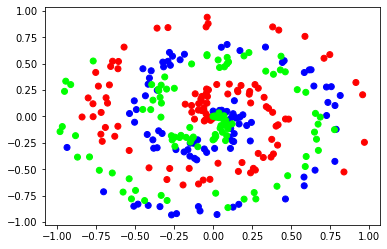

In [54]:

X, y = spiral_data(samples = 100, classes = 3) 
plt.scatter(X[:,0], X[:,1], c=y, cmap='brg') 
plt.show()

In [55]:
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1,n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [56]:
class Activation_ReLu:
    
    def forward(self, inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
        self.dinputs[self.inputs <= 0] = 0

In [57]:
class Activation_Softmax:
    
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis= 1, keepdims=True))
        
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        
        self.output = probabilities
    
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalue) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1,1)
            
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalue)
        

In [58]:
class Loss:
    
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        
        data_loss = np.mean(sample_losses)
        
        return data_loss
    
    def regularization_loss(self,layer):
        regularization_loss = 0
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))  
        
        if layer.weight_regularizer_l2 > 0:
            regularization_loss +=  layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights) 
        
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.bias))  
        
        if layer.bias_regularizer_l2 > 0:
            regularization_loss +=  layer.bias_regularizer_l2 * np.sum(layer.bias * layer.bias)  
            
        return regularization_loss

In [59]:
class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y_true):
        
        samples = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1- 1e-7)
        
        if len(y_true.shape) == 1: 
            correct_confidences = y_pred_clipped[ 
                range(samples), 
                y_true 
            ] 
 
        
        elif len(y_true.shape) == 2: 
            correct_confidences = np.sum( 
                y_pred_clipped * y_true, 
                axis = 1 
            ) 
 
        
        negative_log_likelihoods = -np.log(correct_confidences) 
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
       
        samples = len(dvalues) 
        
        labels = len(dvalues[0]) 
 
        
        if len(y_true.shape) == 1: 
            y_true = np.eye(labels)[y_true] 
 
        
        self.dinputs = -y_true / dvalues 
        
        self.dinputs = self.dinputs / samples 
        
        

In [60]:
class Acuracy:
    
    def calculate(self, inputs, y_true):
        
        predictions = np.argmax(inputs, axis=1)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        acuracy = np.mean(predictions==y_true)
        return acuracy

In [61]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if (len(y_true.shape)==2):
            y_true = np.argmax(y_true, axis = 1)
        
        self.dinputs = dvalues.copy()
        
        self.dinputs[range(samples), y_true] -= 1
        
        self.dinputs = self.dinputs / samples
        

In [62]:
class Optimizer_SDG:
    
    def __init__(self,learning_rate=1, learning_rate_decay = 0, momentum = 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if self.momentum:
            
            if not hasattr(layer, 'weight_momentums'):
                # Store momentums in the layer
                layer.weight_momentums = np.zeros_like(layer.weights)
                
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Update with momentums
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        else:
            # Normal update
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        layer.weights +=  weight_updates
        layer.biases +=  bias_updates
    
    def post_update_params(self):
        self.steps += 1

In [63]:
class Optimizer_AdaGrad:
    
    def __init__(self,learning_rate=1, learning_rate_decay = 0,epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            # Store caches in the layer
            layer.weight_cache = np.zeros_like(layer.weights)
                
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases **2
        
        layer.weights +=  -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases +=  -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    
    def post_update_params(self):
        self.steps += 1

In [64]:
class Optimizer_RMSprop:
    
    def __init__(self,learning_rate=0.001, learning_rate_decay = 0,epsilon = 1e-7, rho = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            # Store caches in the layer
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases ** 2
        
        layer.weights +=  -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases +=  -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    
    def post_update_params(self):
        self.steps += 1

In [65]:
class Optimizer_Adam:
    
    def __init__(self,learning_rate=0.001, learning_rate_decay = 0,epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.steps = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self):
        # Update current learning rate if there is a decay function
        if self.learning_rate_decay:
            self.current_learning_rate = self.learning_rate * (1/ (1+self.learning_rate_decay*self.steps))
        
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            # Store momentums and caches in the layer
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1-self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1-self.beta_1) * layer.dbiases
        
        # Corrected momentums (1 - b_1^step)
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.steps + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.steps + 1))
        
        # Update Cache
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2
        
        # Corrected cache (1 - b_2^step)
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.steps + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.steps + 1))
        
        layer.weights +=  -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases +=  -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.steps += 1

In [66]:
class Layer_Dropout:
    
        def __init__(self, rate):
            # We will be using droput rate and invert for success rate
            self.rate = 1 - rate
        
        def forward(self, inputs):
            self.inputs = inputs
            
            self.binary_mask = np.random.binomial(1, self.rate, size = inputs.shape) / self.rate
            
            self.output = inputs * self.binary_mask
        
        def backward(self, dvalues):
            self.dinputs = self.binary_mask * dvalues

First iteration

In [67]:
#Data
X, y = spiral_data(samples = 100, classes = 3) 

#First layer with 2 inputs and 3 neurons
dense1 = Layer_Dense(2,3)

#ReLu for first layer
activation1 = Activation_ReLu()

#Second layer with 3 inputs(As it uses the outputs from the previous layer) and 3 neurons
dense2 = Layer_Dense(3,3)

#SoftMax for the second layer and for the output
activation2 = Activation_Softmax()

# Create loss function 
loss_function = Loss_CategoricalCrossentropy()

# Create acuracy function 
acuracy_function = Acuracy()

#Forward of our data on the first layer
dense1.forward(X)

#ReLu activation of the data in the first layer
activation1.forward(dense1.output)

#Forward of our outputs fron the ReLu of the first layer
dense2.forward(activation1.output)

#SoftMax activation of the data in the first layer
activation2.forward(dense2.output)

print(activation2.output[:5])

#Loss function of the data of the softmax
loss = loss_function.calculate(activation2.output, y)
print(loss)

#Acuracy function of the data of the softmax
acuracy = acuracy_function.calculate(activation2.output, y)
print(acuracy)



[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.3333333  0.33333334]
 [0.3333335  0.333333   0.33333352]
 [0.33333334 0.33333334 0.33333334]]
1.0986118
0.33666666666666667


Second way

In [68]:
#Data
X, y = spiral_data(samples = 100, classes = 3) 

#First layer with 2 inputs and 64 neurons
dense1 = Layer_Dense(2,64)

#ReLu for first layer
activation1 = Activation_ReLu()

#Second layer with 64 inputs(As it uses the outputs from the previous layer) and 3 neurons
dense2 = Layer_Dense(64,3)

#Softmax with loss for backpropagation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#SDG Optimizer
optimizer = Optimizer_SDG(learning_rate_decay=1e-3,momentum=.9)

#Create acuracy function 
acuracy_function = Acuracy()

for epoch in range(10001):
    #Forward of our data on the first layer
    dense1.forward(X)

    #ReLu activation of the data in the first layer
    activation1.forward(dense1.output)

    #Forward of our outputs fron the ReLu of the first layer
    dense2.forward(activation1.output)

    #SoftMax activation of the data in the first layer
    loss = loss_activation.forward(dense2.output, y)

    #Acuracy function of the data of the softmax
    accuracy = acuracy_function.calculate(loss_activation.output, y)

    
    if not epoch % 100: 
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}') 

    # Backward pass 
    loss_activation.backward(loss_activation.output, y) 
    dense2.backward(loss_activation.dinputs) 
    activation1.backward(dense2.dinputs) 
    dense1.backward(activation1.dinputs) 

    #Using sdg to update params
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2) 
    optimizer.post_update_params()


epoch: 0, acc: 0.337, loss: 1.099, lr: 1
epoch: 100, acc: 0.430, loss: 1.068, lr: 0.9099181073703367
epoch: 200, acc: 0.417, loss: 1.004, lr: 0.8340283569641367
epoch: 300, acc: 0.563, loss: 0.845, lr: 0.7698229407236336
epoch: 400, acc: 0.613, loss: 0.761, lr: 0.7147962830593281
epoch: 500, acc: 0.643, loss: 0.714, lr: 0.66711140760507
epoch: 600, acc: 0.670, loss: 0.690, lr: 0.6253908692933083
epoch: 700, acc: 0.657, loss: 0.676, lr: 0.5885815185403178
epoch: 800, acc: 0.667, loss: 0.667, lr: 0.5558643690939411
epoch: 900, acc: 0.677, loss: 0.659, lr: 0.526592943654555
epoch: 1000, acc: 0.677, loss: 0.652, lr: 0.5002501250625312
epoch: 1100, acc: 0.673, loss: 0.646, lr: 0.4764173415912339
epoch: 1200, acc: 0.677, loss: 0.641, lr: 0.45475216007276037
epoch: 1300, acc: 0.677, loss: 0.606, lr: 0.43497172683775553
epoch: 1400, acc: 0.750, loss: 0.524, lr: 0.4168403501458941
epoch: 1500, acc: 0.780, loss: 0.506, lr: 0.4001600640256102
epoch: 1600, acc: 0.790, loss: 0.496, lr: 0.3847633705

In [69]:
#Data
X, y = spiral_data(samples = 100, classes = 3) 

#First layer with 2 inputs and 64 neurons
dense1 = Layer_Dense(2,64)

#ReLu for first layer
activation1 = Activation_ReLu()

dropout1 = Layer_Dropout(0.1) 

#Second layer with 64 inputs(As it uses the outputs from the previous layer) and 3 neurons
dense2 = Layer_Dense(64,3)

#Softmax with loss for backpropagation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

#SDG Optimizer
optimizer = Optimizer_Adam(learning_rate=0.05, learning_rate_decay=5e-7)

#Create acuracy function 
acuracy_function = Acuracy()

for epoch in range(10001):
    #Forward of our data on the first layer
    dense1.forward(X)

    #ReLu activation of the data in the first layer
    activation1.forward(dense1.output)

    #Forward of our outputs fron the ReLu of the first layer
    dense2.forward(activation1.output)

    #SoftMax activation of the data in the first layer
    loss = loss_activation.forward(dense2.output, y)

    #Acuracy function of the data of the softmax
    accuracy = acuracy_function.calculate(loss_activation.output, y)

    
    if not epoch % 100: 
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}') 

    # Backward pass 
    loss_activation.backward(loss_activation.output, y) 
    dense2.backward(loss_activation.dinputs) 
    activation1.backward(dense2.dinputs) 
    dense1.backward(activation1.dinputs) 

    #Using sdg to update params
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2) 
    optimizer.post_update_params()


epoch: 0, acc: 0.310, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.630, loss: 0.834, lr: 0.04999752512250644
epoch: 200, acc: 0.730, loss: 0.678, lr: 0.04999502549496326
epoch: 300, acc: 0.763, loss: 0.573, lr: 0.049992526117345455
epoch: 400, acc: 0.810, loss: 0.501, lr: 0.04999002698961558
epoch: 500, acc: 0.790, loss: 0.477, lr: 0.049987528111736124
epoch: 600, acc: 0.837, loss: 0.427, lr: 0.049985029483669646
epoch: 700, acc: 0.853, loss: 0.404, lr: 0.049982531105378675
epoch: 800, acc: 0.860, loss: 0.380, lr: 0.04998003297682575
epoch: 900, acc: 0.863, loss: 0.364, lr: 0.049977535097973466
epoch: 1000, acc: 0.870, loss: 0.347, lr: 0.049975037468784345
epoch: 1100, acc: 0.883, loss: 0.342, lr: 0.049972540089220974
epoch: 1200, acc: 0.887, loss: 0.324, lr: 0.04997004295924593
epoch: 1300, acc: 0.867, loss: 0.330, lr: 0.04996754607882181
epoch: 1400, acc: 0.900, loss: 0.295, lr: 0.049965049447911185
epoch: 1500, acc: 0.913, loss: 0.287, lr: 0.04996255306647668
epoch: 1600, acc: 0.917, lo

In [70]:
import numpy as np
softmax_outputs = np.array([[0.8, 0.1, 0.2], 
                            [0.1, 0.5, 0.4], 
                            [0.02, 0.9, 0.08]]) 
class_targets = np.array([[1, 0, 0], 
                          [0, 1, 0], 
                          [0, 1, 0]]) 

print(np.argmax(class_targets, axis=1))
print(np.max(softmax_outputs, axis= 1, keepdims=True))

correct_confidences = np.sum( 
    softmax_outputs * class_targets, 
    axis = 1
    )
print(correct_confidences)
pred = -np.log(correct_confidences)
np.mean(pred)

[0 1 1]
[[0.8]
 [0.5]
 [0.9]]
[0.8 0.5 0.9]


0.34055041584399376

In [71]:
inputs = np.array([[6,1,1]])

exp_values = np.exp(inputs - np.max(inputs, axis= 1, keepdims=True))
print(np.max(inputs, axis= 1, keepdims=True))
print(exp_values)
print(np.sum(exp_values, axis=1,keepdims=True))
        
probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
print(probabilities)

[[6]]
[[1.         0.00673795 0.00673795]]
[[1.01347589]]
[[0.98670329 0.00664835 0.00664835]]
